<a href="https://colab.research.google.com/github/chimaOkwuokei/ISEND-PAU/blob/main/FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of d so we will re-download the data.
94773248/94765736 [==============================] - 5s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Response map shape :  (1, 1000, 3, 8)
tf.Tensor(
[[[978 437 437 437 437 978 354 975]
  [978 354 354 354 354 354 354 735]
  [978 977 977 977 977 273 354 354]]], shape=(1, 3, 8), dtype=int64)
Predicted Class :  Arabian camel, dromedary, Camelus dromedarius tf.Tensor(354, shape=(), dtype=int64)


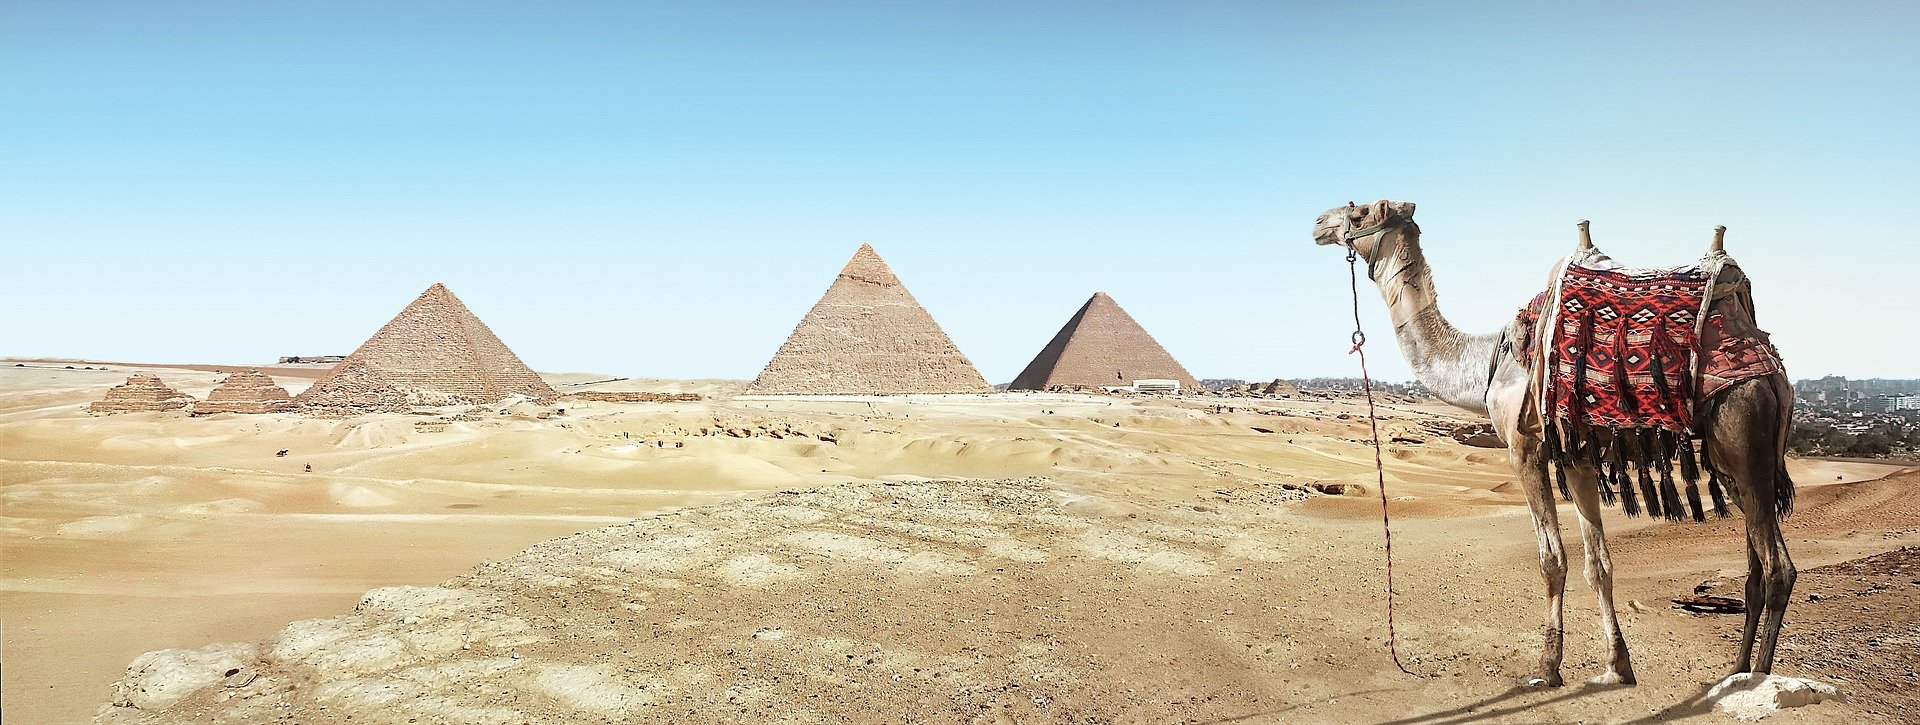

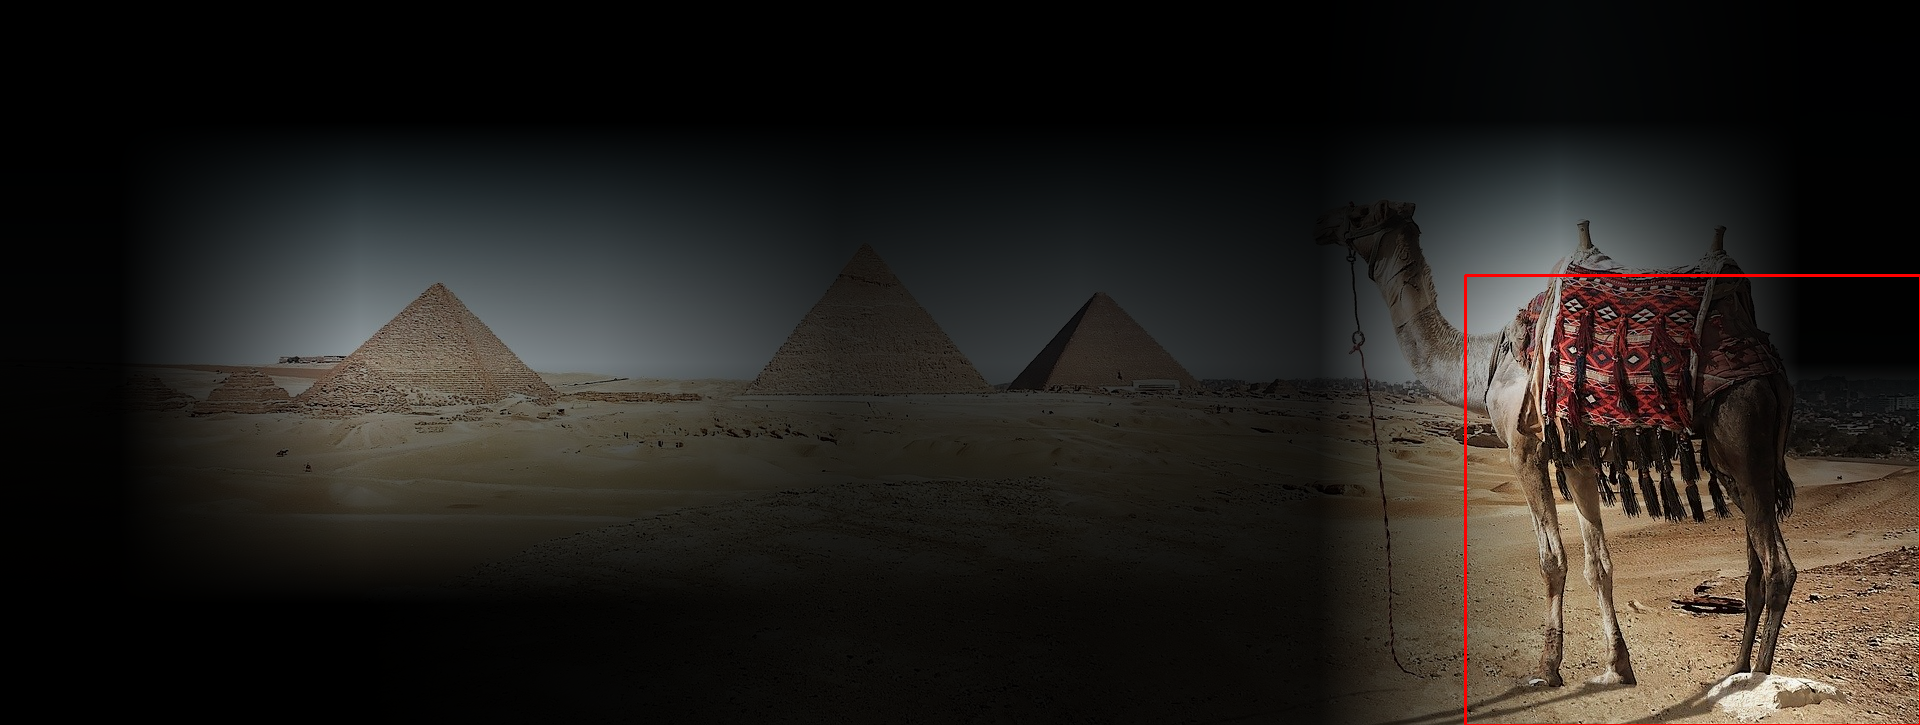

0.0014068558
0.99743235
[[2.4525475e-04 2.4525475e-04 2.4525475e-04 ... 4.5540114e-03
  4.5540114e-03 4.5540114e-03]
 [2.4525475e-04 2.4525475e-04 2.4525475e-04 ... 4.5540114e-03
  4.5540114e-03 4.5540114e-03]
 [2.4525475e-04 2.4525475e-04 2.4525475e-04 ... 4.5540114e-03
  4.5540114e-03 4.5540114e-03]
 ...
 [3.0128688e-03 3.0128688e-03 3.0128688e-03 ... 9.8344994e-01
  9.8344994e-01 9.8344994e-01]
 [3.0128688e-03 3.0128688e-03 3.0128688e-03 ... 9.8344994e-01
  9.8344994e-01 9.8344994e-01]
 [3.0128688e-03 3.0128688e-03 3.0128688e-03 ... 9.8344994e-01
  9.8344994e-01 9.8344994e-01]]


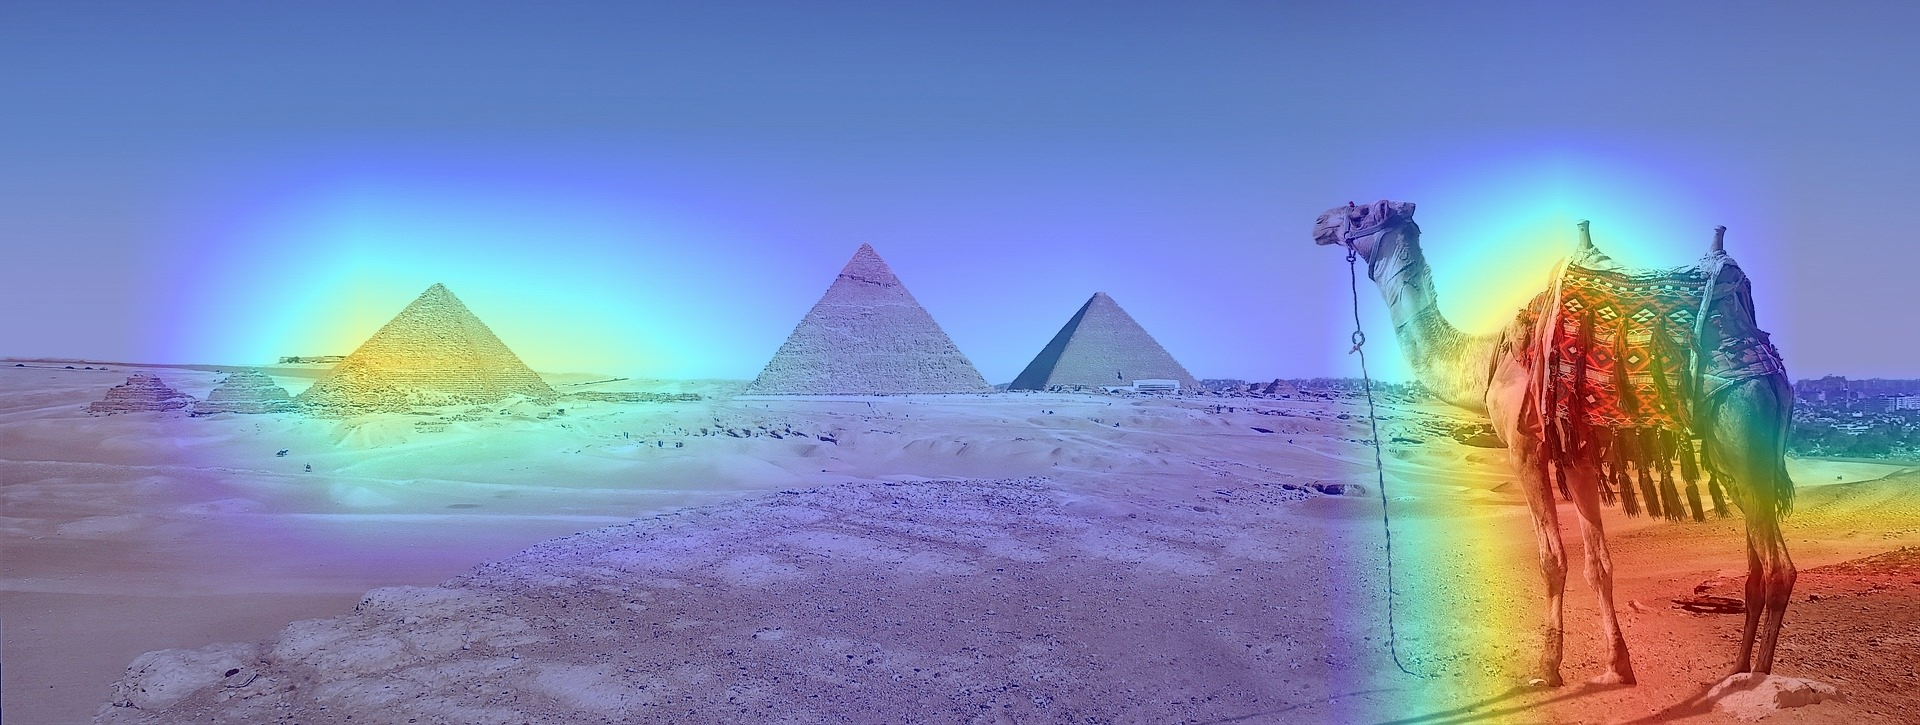

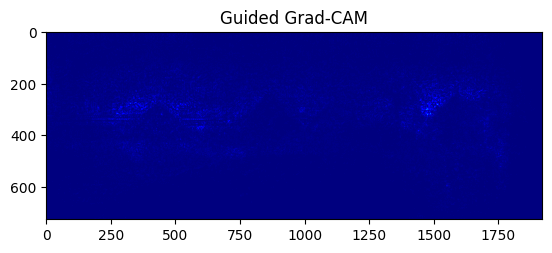

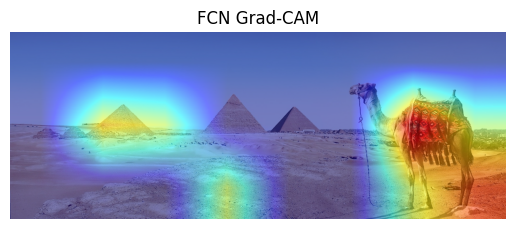

In [10]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import (
    Activation,
    AveragePooling2D,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    ZeroPadding2D,
)
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils import data_utils
from google.colab.patches import cv2_imshow
from utils import (
    BASE_WEIGHTS_PATH,
    WEIGHTS_HASHES,
    stack1,
)
import matplotlib.pyplot as plt


# Set seed for reproducibility
def set_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_seed()  # Set seed for consistent results

# setting FC weights to the final convolutional layer
def set_conv_weights(model, feature_extractor):
    # get pre-trained ResNet50 FC weights
    dense_layer_weights = feature_extractor.layers[-1].get_weights()
    weights_list = [
        tf.reshape(
            dense_layer_weights[0], (1, 1, *dense_layer_weights[0].shape),
        ).numpy(),
        dense_layer_weights[1],
    ]
    model.get_layer(name="last_conv").set_weights(weights_list)


# Fully convolutional ResNet50 model
def fully_convolutional_resnet50(input_shape, num_classes=1000, pretrained_resnet=True, use_bias=True):
    img_input = Input(shape=input_shape)

    x = ZeroPadding2D(padding=((3, 3), (3, 3)), name="conv1_pad")(img_input)
    x = Conv2D(64, 7, strides=2, use_bias=use_bias, name="conv1_conv")(x)
    x = BatchNormalization(axis=3, epsilon=1.001e-5, name="conv1_bn")(x)
    x = Activation("relu", name="conv1_relu")(x)

    x = ZeroPadding2D(padding=((1, 1), (1, 1)), name="pool1_pad")(x)
    x = MaxPooling2D(3, strides=2, name="pool1_pool")(x)

    x = stack1(x, 64, 3, stride1=1, name="conv2")
    x = stack1(x, 128, 4, name="conv3")
    x = stack1(x, 256, 6, name="conv4")
    x = stack1(x, 512, 3, name="conv5")

    x = AveragePooling2D(pool_size=7)(x)

    conv_layer_final = Conv2D(filters=num_classes, kernel_size=1, use_bias=use_bias, name="last_conv")(x)

    #
    model = Model(inputs=img_input, outputs=[x])

    # load model weights
    if pretrained_resnet:
        model_name = "resnet50"
        # configure full file name
        file_name = model_name + "_weights_tf_dim_ordering_tf_kernels_notop.h5"
        # get the file hash from TF WEIGHTS_HASHES
        file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = data_utils.get_file(
            file_name,
            BASE_WEIGHTS_PATH + file_name,
            cache_subdir="models",
            file_hash=file_hash,
        )

        model.load_weights(weights_path)

    # form final model
    model = Model(inputs=model.input, outputs=[conv_layer_final])

    if pretrained_resnet:
        # get model with the dense layer for further FC weights extraction
        resnet50_extractor = ResNet50(
            include_top=True, weights="imagenet", classes=num_classes,
        )
        # set ResNet50 FC-layer weights to final convolutional layer
        set_conv_weights(model=model, feature_extractor=resnet50_extractor)
    return model


# Generate Score Map for FCN
def generate_score_map(preds, predicted_class, original_image):
    # Get score map for predicted class
    score_map = tf.expand_dims(preds[0, predicted_class, :, :], 0).numpy()
    score_map = score_map[0]

    # Resize score map to match original image
    score_map = cv2.resize(score_map, (original_image.shape[1], original_image.shape[0]))

    # Apply threshold to binarize the score map
    _, score_map_for_contours = cv2.threshold(score_map, 0.65, 1, type=cv2.THRESH_BINARY)
    score_map_for_contours = score_map_for_contours.astype(np.uint8).copy()

    return score_map, score_map_for_contours


def generate_cam(preds, original_image, predicted_class):
    # Extract the class activation map (CAM) for the predicted class, and convert to numpy
    cam = preds[0, predicted_class, :, :].numpy().astype(np.float32)

    # Resize CAM to the same dimensions as the original image
    cam = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))

    # Normalize CAM between 0 and 1
    cam_min = np.min(cam) #cam value of 0.00...
    print(cam_min)
    cam_max = np.max(cam) #cam value of 0.99...
    print(cam_max)


    if cam_max > cam_min:
        # Standard normalization if cam_min != cam_max
        cam = (cam - cam_min) / (cam_max - cam_min)
        print(cam)
    else:
        # If the CAM is uniform, set all values to 0
        cam = np.zeros_like(cam)

    return cam



def guided_backprop(model, image):
    with tf.GradientTape() as tape:
        tape.watch(image)
        preds = model(image)
        loss = tf.reduce_mean(preds)  # Can focus on specific class

    # Compute gradient of loss with respect to input image
    grads = tape.gradient(loss, image)

    # Only retain positive gradients
    guided_grads = tf.cast(grads > 0, "float32") * grads
    return guided_grads.numpy()

def guided_grad_cam(cam, guided_grads):
    # Element-wise multiplication of guided backprop gradients with CAM
    combined = cam * guided_grads[0]
    combined = np.max(combined, axis=-1)
    combined = np.maximum(combined, 0)
    combined = combined / combined.max()
    return combined


def generate_fcn_grad_cam(model, image, predicted_class):
    # Use GradientTape to get gradients of the predicted class w.r.t. the feature maps
    with tf.GradientTape() as tape:
        conv_outputs = model(image)
        predicted_class_score = conv_outputs[:, :, :, predicted_class]

    # Get gradients of predicted class w.r.t. feature map
    grads = tape.gradient(predicted_class_score, conv_outputs)

    # Normalize the gradients to reduce noise
    norm_grads = tf.math.l2_normalize(grads, axis=(0, 1, 2))
    pooled_grads = tf.reduce_mean(norm_grads, axis=(0, 1, 2))

    # Multiply each channel by its gradient importance
    conv_outputs = conv_outputs[0]
    conv_outputs = tf.einsum('ijk,k->ijk', conv_outputs, pooled_grads)

    # Generate heatmap by averaging over all channels
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU to remove negative values
    heatmap /= np.max(heatmap)  # Normalize to [0,1]

    # Optionally threshold the heatmap to focus on more relevant features
    threshold = 0.5
    heatmap[heatmap < threshold] = 0

    return heatmap

# Reverse color mapping if needed to focus red on important features
def overlay_heatmap(heatmap, img_path, intensity=0.5, reverse=True):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Optionally reverse the heatmap
    if reverse:
        heatmap = 1 - heatmap

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # Superimpose the heatmap on original image
    superimposed_img = cv2.addWeighted(img, 1 - intensity, heatmap, intensity, 0)
    return superimposed_img

if __name__ == "__main__":
    # Load and preprocess image
    # read ImageNet class ids to a list of labels
    with open("imagenet_classes.txt") as f:
        labels = [line.strip() for line in f.readlines()]

    original_image = cv2.imread("camel.jpg")
    image_path = "/content/camel.jpg"
    image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    image = tf.expand_dims(image, 0)

    # Set seed before predictions
    set_seed()

    # Load model
    model = fully_convolutional_resnet50(input_shape=(image.shape[-3:]), num_classes=1000)

    # Perform inference.
    # Instead of a 1×1000 vector, we will get a
    # 1×1000×n×m output ( i.e. a probability map
    # of size n × m for each 1000 class,
    # where n and m depend on the size of the image).
    preds = model.predict(image)
    preds = tf.transpose(preds, perm=[0, 3, 1, 2])
    preds = tf.nn.softmax(preds, axis=1)
    print("Response map shape : ", preds.shape)


    # find the class with the maximum score in the n × m output map
    pred = tf.math.reduce_max(preds, axis=1)
    class_idx = tf.math.argmax(preds, axis=1)
    print(class_idx)

    row_max = tf.math.reduce_max(pred, axis=1)
    row_idx = tf.math.argmax(pred, axis=1)
    col_idx = tf.math.argmax(row_max, axis=1)

    predicted_class = tf.gather_nd(class_idx, (0, tf.gather_nd(row_idx, (0, col_idx[0])), col_idx[0]))
    print("Predicted Class : ", labels[predicted_class], predicted_class)

    # Generate Score Map
    score_map, score_map_for_contours = generate_score_map(preds, predicted_class, original_image)

    # Find contours and bounding box
    contours, _ = cv2.findContours(score_map_for_contours, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    rect = cv2.boundingRect(contours[0])

    # Apply score map as a mask
    score_map = score_map - np.min(score_map[:])
    score_map = score_map / np.max(score_map[:])
    score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2BGR)
    masked_image = (original_image * score_map).astype(np.uint8)

    # Display bounding box
    cv2.rectangle(masked_image, rect[:2], (rect[0] + rect[2], rect[1] + rect[3]), (0, 0, 255), 2)

    # Display Score Map and masked image
    cv2_imshow(original_image)
    # cv2_imshow(score_map)
    cv2_imshow(masked_image)



    #so CAM(class activation map) works
    # Generate and display CAM
    cam_output = generate_cam(preds, original_image, predicted_class)
    cam_output = np.uint8(255 * cam_output)
    cam_output = cv2.applyColorMap(cam_output, cv2.COLORMAP_JET)
    superimposed_cam = cv2.addWeighted(original_image, 0.6, cam_output, 0.4, 0)
    cv2_imshow(superimposed_cam)


    #focuses on pixel wise contributions
    #Generate guided Grad-CAM
    guided_grads = guided_backprop(model, image)
    guided_grad_cam_output = guided_grad_cam(cam_output, guided_grads)
    plt.imshow(guided_grad_cam_output, cmap='jet')
    plt.title('Guided Grad-CAM')
    plt.show()

    #grad cam
    # Generate Grad-CAM heatmap for the predicted class
    heatmap = generate_fcn_grad_cam(model, image, predicted_class)
    # Overlay heatmap on original image
    superimposed_img = overlay_heatmap(heatmap, image_path)
    # Display the superimposed image
    plt.imshow(superimposed_img)
    plt.title("FCN Grad-CAM")
    plt.axis('off')
    plt.show()


    cv2.waitKey(0)
    cv2.destroyAllWindows()

